# Create Dataset Summary Plots

## 1. Import required Python libraries

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import LC_Grid_Labels as lc
import cartopy
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import IPython

### 1. a. Print session and library version numbers  

In [2]:
# Print IPython Session Info
print(IPython.sys_info())

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("scipy version: " + scipy.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("cartopy: " + cartopy.__version__)
print("wrf-python version: " + wrf.__version__+"\n")

{'commit_hash': '8c47bbcb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/lejoflores/miniconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.5.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.6.0-x86_64-i386-64bit',
 'sys_executable': '/Users/lejoflores/miniconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.3 (default, Mar 27 2019, 16:54:48) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}

Package version numbers:

xarray version: 0.12.1
numpy version: 1.16.3
scipy version: 1.2.1
matplotlib version: 3.0.3
cartopy: 0.17.0
wrf-python version: 1.3.2



## 2. Read in the data using `xarray`

In [3]:
wrf_dir = '/Users/lejoflores/data/WRF-NARR-1km-Daily/'

ds_wrf = xr.open_mfdataset(wrf_dir+'WRF-NARR*.nc')

### 2. a. Create a Water Year vector to use as a grouping variable

In [4]:
WY1 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] >= 10).values + 1)
WY2 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] < 10).values)

WY = np.nansum(np.column_stack((WY1,WY2)),axis=1)
print(WY.astype(int))

[1988 1988 1988 ... 2017 2017 2017]


### 2. b. Add the grouping vector to the dataset

In [5]:
ds_wrf.coords['WY'] = xr.DataArray(WY.astype(int),dims='XTIME')
ds_wrf

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
    WY       (XTIME) int64 1988 1988 1988 1988 1988 ... 2017 2017 2017 2017 2017
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366

## 3. Compute Mean Annual Precipitation and Mean Annual Temperature

Note that some values of annual precipitation are sufficiently close to zero that ```numpy``` gives a divide by zero warning when computing the coefficient of variation in annual precipitation. To get around this warning the annual precipitation array is multiplied by 1000.0 (effectively converting to values of microns) before computing the coefficient of variation.

In [6]:
da_MAP       = ds_wrf['DPRCP'].groupby('WY').sum(dim='XTIME').mean(dim='WY')
da_MATmin    = ds_wrf['TMIN'].groupby('WY').mean(dim='XTIME').mean(dim='WY')
da_MATmax    = ds_wrf['TMAX'].groupby('WY').mean(dim='XTIME').mean(dim='WY')
da_StDAP     = ds_wrf['DPRCP'].groupby('WY').sum(dim='XTIME').std(dim='WY')
da_StDATmin  = ds_wrf['TMIN'].groupby('WY').mean(dim='XTIME').std(dim='WY')
da_StDATmax  = ds_wrf['TMAX'].groupby('WY').mean(dim='XTIME').std(dim='WY')
da_CVAP      = stats.variation((ds_wrf['DPRCP'].groupby('WY').sum(dim='XTIME') + 0.001).values)
da_CVATmin   = stats.variation(ds_wrf['TMIN'].groupby('WY').mean(dim='XTIME').values)
da_CVATmax   = stats.variation(ds_wrf['TMAX'].groupby('WY').mean(dim='XTIME').values)

## 4. Create a 3 x 3 plot of climate data summary

Set the colormap, the file names for each of the figures, get the latitude and longitude coordinates for WRF, and create vector coverages of state boundaries and major rivers for reference in the figures. Note that we have decided not to implement subplots in these figures, opting instead to create subplots in LaTex during manuscript preparation

In [7]:
ColorMap_prcp = 'YlGnBu'
ColorMap_temp = 'Spectral_r'
ColorMap_CV = 'plasma'

contour_levels = 15

figsize_in = (14.5,12)
figres_dpi = 300
figext = '.tif'

ClimSummary_fname  = 'fig/2_AnnualClimateStatistics'+figext

ds_wrfgeo = xr.open_dataset(wrf_dir+'wrf_geoinfo.nc')
nc_wrfgeo = nc.Dataset(wrf_dir+'wrf_geoinfo.nc')
cart_proj = get_cartopy(wrfin=nc_wrfgeo)

lats, lons = latlon_coords(ds_wrfgeo)

lat = lats[0]
lon = lons[0]

states = NaturalEarthFeature(category='cultural', scale='10m',facecolor='none',name='admin_1_states_provinces_shp')
rivers = NaturalEarthFeature(category='physical',scale='10m',facecolor='none',name='rivers_lake_centerlines')

plt.rcParams.update({'font.size': 11, 'font.family':'sans-serif'})

### 4. a. Plot statistics of annual totals and averages

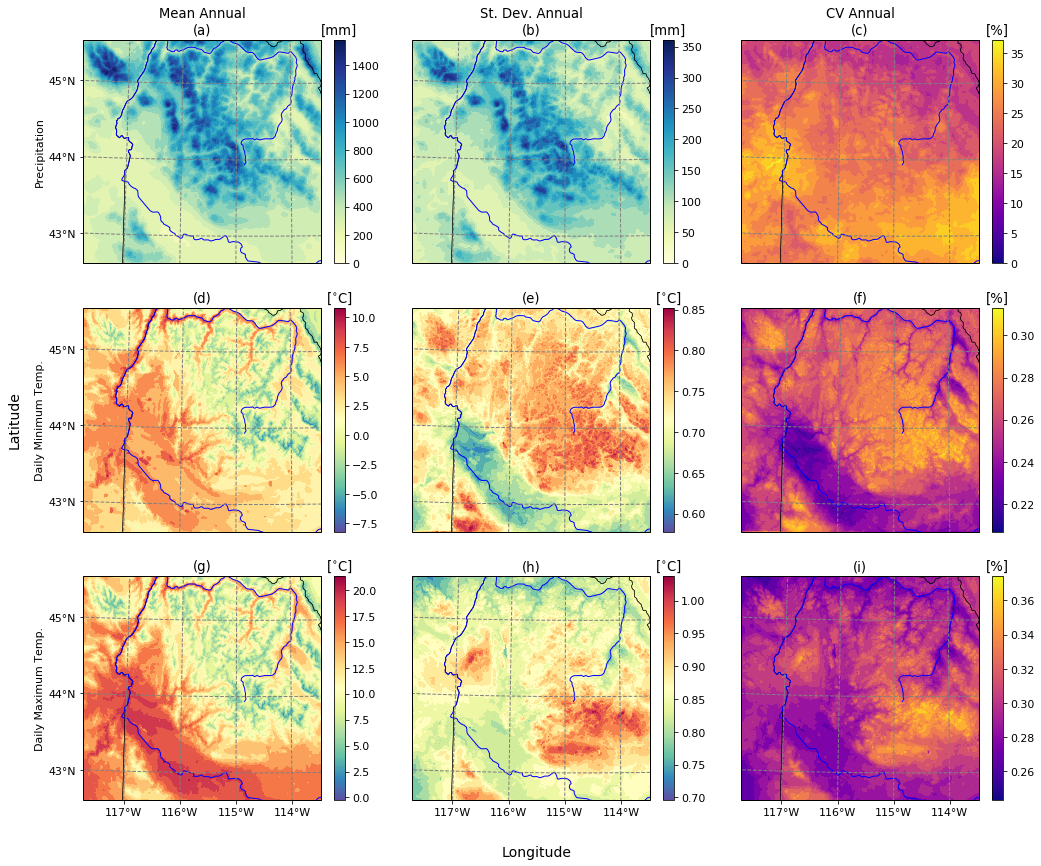

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize = figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),da_MAP,contour_levels,transform=crs.PlateCarree(),
                           cmap=ColorMap_prcp)
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),da_StDAP,contour_levels,transform=crs.PlateCarree(),
                           cmap=ColorMap_prcp)
im13 = axes[0][2].contourf(to_np(lon),to_np(lat),da_CVAP*100.0,contour_levels,
                           transform=crs.PlateCarree(),cmap=ColorMap_CV)

im21 = axes[1][0].contourf(to_np(lon),to_np(lat),da_MATmin-273.15,contour_levels,transform=crs.PlateCarree(),
                           cmap=ColorMap_temp)
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),da_StDATmin,contour_levels,transform=crs.PlateCarree(),
                           cmap=ColorMap_temp)
im23 = axes[1][2].contourf(to_np(lon),to_np(lat),da_CVATmin*100.0,contour_levels,
                           transform=crs.PlateCarree(),cmap=ColorMap_CV)

im31 = axes[2][0].contourf(to_np(lon),to_np(lat),da_MATmax-273.15,contour_levels,transform=crs.PlateCarree(),
                           cmap=ColorMap_temp)
im32 = axes[2][1].contourf(to_np(lon),to_np(lat),da_StDATmax,contour_levels,transform=crs.PlateCarree(),
                           cmap=ColorMap_temp)
im33 = axes[2][2].contourf(to_np(lon),to_np(lat),da_CVATmax*100.0,contour_levels,
                           transform=crs.PlateCarree(),cmap=ColorMap_CV)

xticks = [-118,-117,-116,-115,-114,-113]
yticks = [42,43,44,45,46]

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    
    if(ax.rowNum==2):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)
        
axes[0][0].set_title('Mean Annual\n(a)')
axes[0][1].set_title('St. Dev. Annual\n(b)')
axes[0][2].set_title('CV Annual\n(c)')
axes[1][0].set_title('(d)')
axes[1][1].set_title('(e)')
axes[1][2].set_title('(f)')
axes[2][0].set_title('(g)')
axes[2][1].set_title('(h)')
axes[2][2].set_title('(i)')

axes[0][0].set_ylabel('Precipitation')
axes[1][0].set_ylabel('Daily Minimum Temp.')
axes[2][0].set_ylabel('Daily Maximum Temp.')

m11 = plt.cm.ScalarMappable(cmap=cm.YlGnBu)
m11.set_array(to_np(da_MAP))
clb11 = fig.colorbar(m11,ax=axes[0][0],fraction=0.046, pad=0.04)
clb11.ax.set_title('[mm]')

m12 = plt.cm.ScalarMappable(cmap=cm.YlGnBu)
m12.set_array(to_np(da_StDAP))
clb12 = fig.colorbar(m12,ax=axes[0][1],fraction=0.046, pad=0.04)
clb12.ax.set_title('[mm]')

m13 = plt.cm.ScalarMappable(cmap=cm.plasma)
m13.set_array(to_np(da_CVAP*100.0))
clb13 = fig.colorbar(m13,ax=axes[0][2],fraction=0.046, pad=0.04)
clb13.ax.set_title('[%]')

m21 = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m21.set_array(to_np(da_MATmin - 273.15))
clb21 = fig.colorbar(m21,ax=axes[1][0],fraction=0.046, pad=0.04)
clb21.ax.set_title('[${}^{\circ}$C]')

m22 = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m22.set_array(to_np(da_StDATmin))
clb22 = fig.colorbar(m22,ax=axes[1][1],fraction=0.046, pad=0.04)
clb22.ax.set_title('[${}^{\circ}$C]')

m23 = plt.cm.ScalarMappable(cmap=cm.plasma)
m23.set_array(to_np(da_CVATmin*100.0))
clb23 = fig.colorbar(m23,ax=axes[1][2],fraction=0.046, pad=0.04)
clb23.ax.set_title('[%]')

m31 = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m31.set_array(to_np(da_MATmax - 273.15))
clb31 = fig.colorbar(m31,ax=axes[2][0],fraction=0.046, pad=0.04)
clb31.ax.set_title('[${}^{\circ}$C]')

m32 = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m32.set_array(to_np(da_StDATmax))
clb32 = fig.colorbar(m32,ax=axes[2][1],fraction=0.046, pad=0.04)
clb32.ax.set_title('[${}^{\circ}$C]')

m33 = plt.cm.ScalarMappable(cmap=cm.plasma)
m33.set_array(to_np(da_CVATmax*100.0))
clb33 = fig.colorbar(m33,ax=axes[2][2],fraction=0.046, pad=0.04)
clb33.ax.set_title('[%]')


fig.text(0.5, 0.00, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)
        
plt.savefig(ClimSummary_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', orientation='landscape', bbox_inches='tight')
plt.show()